In [2]:
"""
## 0. Environment setup
Installs extra packages if they are missing (safe to re‑run).
If you already have the correct environment – *skip*.
"""

# %%
# Install dependencies (quietly)
# Colab already has most of these; the cell is idempotent
!pip install -q transformers==4."*" tokenizers==0."*" pandas matplotlib seaborn nltk


In [3]:
"""
## 1. Configuration – **edit only this cell if you want to change behaviour**
The defaults mirror the settings in the original script.
"""

# %%
# === USER CONFIGURATION ===
USE_NLTK = True
USE_SECOND_PASS_CENSOR = True      # Toggle the second‑pass censor based on name‑dictionary
MAX_CHARS_PER_BATCH    = 1000      # Sub‑batch size when processing long chats
TIME_GAP_HOURS         = 24        # Gap (hrs) that starts a new message_id

# Datasets: (tag, raw chat .txt, gold .xlsx)
DATASETS = [
    ("DOG",      "DOG.txt",      "NEW_DOG_GOLD.xlsx"),
    ("BUILDING", "BUILDING.txt", "NEW_BUILDING_GOLD.xlsx"),
    ("CHAT",     "CHAT_PRO.txt", "NEW_CHAT_GOLD.xlsx"),
]

CONCAT_RAW = True   # Build one big ALL_CHATS.txt for manual inspection
# === END CONFIGURATION ===

In [4]:
"""
## 2. Imports & global helpers
Nothing changed here except extra doc‑strings for clarity.
"""

# %%
import re, unicodedata, ast, warnings, os, pandas as pd
from collections import defaultdict, Counter
from typing import List, Dict, Any

import matplotlib.pyplot as plt
import seaborn as sns

if USE_NLTK:
    import nltk
    warnings.filterwarnings("ignore", category=UserWarning)
    try:
        nltk.data.find("corpora/stopwords")
    except LookupError:
        nltk.download("stopwords")
    from nltk.corpus import stopwords
    HEB_STOP: set = set(stopwords.words("hebrew"))
else:
    HEB_STOP: set = set()          # Empty set – no filtering

from transformers import AutoTokenizer, pipeline
from tokenizers.decoders import WordPiece
import torch

# Determine Colab / local
try:
    from google.colab import files
    COLAB = True
except ImportError:
    COLAB = False


PREFIXES = ["", "ל", "מ", "כש", "ש", "ו", "וש"]

def generate_hebrew_variants(name: str) -> set:
    """Return prefixed variants (e.g. "לניר", "כשגיא") – only if base≥2 chars & variant≥3."""
    if len(name) < 2:
        return set()
    return {p + name for p in PREFIXES if len(p + name) >= 3}

def improved_name_pattern(name: str) -> str:
    """Regex enforcing whole‑word match for Hebrew letters only."""
    return rf"(?<![א-ת]){re.escape(name)}(?![א-ת])"

def overlap_range(s1: int, e1: int, s2: int, e2: int) -> bool:
    """Return *True* if (s1,e1) overlaps (s2,e2)."""
    return not (e1 <= s2 or s1 >= e2)

In [5]:
"""
## 3. `data_processing` – load & pre‑process raw WhatsApp export
"""

# %%
class data_processing:
    """Helper that loads a WhatsApp text export into a tidy DataFrame."""

    def __init__(self):
        self.df: pd.DataFrame | None = None

    # ---------- cleaning ----------
    @staticmethod
    def clean_hebrew_text(txt: str) -> str:
        txt = unicodedata.normalize("NFC", txt)
        txt = re.sub(r"[\U00010000-\U0010FFFF]+", "", txt)  # strip emojis
        txt = re.sub(r"\u200f|<המדיה לא נכללה>|<ההודעה נערכה>|הודעה זו נמחקה", "", txt)
        return txt

    # ---------- loading ----------
    def load_chat(self, fpath: str) -> None:
        """Parse WhatsApp TXT to DataFrame with columns: date, time, sender, content, id."""
        with open(fpath, "r", encoding="utf-8") as f:
            content = f.read()
        pat = r"(\d{1,2}\.\d{1,2}\.\d{4}),\s(\d{1,2}:\d{2})\s-\s([^:]+):\s(.+)"
        rows = []
        for line in content.split("\n"):
            m = re.match(pat, line)
            if m:
                d, t, s, msg = m.groups()
                rows.append({"date": d, "time": t, "sender": s,
                             "content": self.clean_hebrew_text(msg)})
        df = pd.DataFrame(rows)
        df = df[df["content"].astype(bool)].reset_index(drop=True)
        df["id"] = df.index + 1
        self.df = df

    # ---------- message‑id grouping ----------
    def add_message_id(self, time_gap_hours: int = 24) -> None:
        df = self.df
        df["dt"] = pd.to_datetime(df["date"] + " " + df["time"], format="%d.%m.%Y %H:%M")
        df.sort_values("dt", inplace=True)
        mids, prev, mid = [], None, 1
        for dt in df["dt"]:
            if prev is not None and (dt - prev).total_seconds() >= time_gap_hours * 3600:
                mid += 1
            mids.append(mid)
            prev = dt
        df["message_id"] = mids
        df.drop(columns="dt", inplace=True)

    # ---------- accessor ----------
    def get_df(self) -> pd.DataFrame:
        return self.df.copy()

In [6]:

"""
## 4. `RollingAnonymizer`
A context-aware anonymization class for chat data.
It detects and masks named entities using NER models, while preserving format and consistency across messages.
Supports dynamic dictionaries, rare-entity boosting, and rolling memory of past identifications.
"""

# %%
class RollingAnonymizer:
    """Streaming NER‑driven anonymizer with a rolling name dictionary."""
    FAMILY_PAT = re.compile(r"(?:[לכשבה]?משפחת)\s+([א-ת]{2,})")

    def __init__(self, *, max_chars: int = 1000, prob_threshold: float = 0.35, time_gap_hours: int = 24):
        import torch
        device = 0 if torch.cuda.is_available() else -1

        # ── Shared tokenizer (base) ───────────────────────────
        tok_base = AutoTokenizer.from_pretrained(
            "dicta-il/dictabert-ner", use_fast=True)
        tok_base.model_max_length = 512
        tok_base.truncation_side  = "right"

        tok_large = AutoTokenizer.from_pretrained(
            "dicta-il/dictabert-large-ner", use_fast=True)
        tok_large.model_max_length = 512
        tok_large.truncation_side  = "right"

        # Important: use WordPiece decoder so that the start/end positions are correct
        for tok in (tok_base, tok_large):
            tok.backend_tokenizer.decoder = WordPiece()

        self.ner_base  = pipeline(
            "ner",
            model="dicta-il/dictabert-ner",
            tokenizer=tok_base,
            aggregation_strategy="simple",
            device=device)

        self.ner_large = pipeline(
            "ner",
            model="dicta-il/dictabert-large-ner",
            tokenizer=tok_large,
            aggregation_strategy="simple",
            device=device)



        self.max_chars = max_chars
        self.prob_thr  = prob_threshold
        self.time_gap_hours = time_gap_hours  # kept for completeness

        # Rolling dictionaries / counters
        self.name_dict_raw: set = set()
        self.name_dict: set     = set()
        self.freq_total: Counter[str] = Counter()
        self.freq_per:   Counter[str] = Counter()

    # -------- regex based anon helpers (unchanged) --------
    @staticmethod
    def regex_anonymizer(text: str) -> List[Dict[str, Any]]:
        pats = {
            "phone":       r"(?:\+?972|0)[-\s]?(?:[23489]|5\d)[-\s]?\d{3}[-\s]?\d{4}\b",
            "id":          r"\b\d{9}\b",
            "email":       r"\b[\w\.-]+@[\w\.-]+\.\w+\b",
            "credit_card": r"\b(?:\d{4}[-\s]?){3}\d{4}\b",
            "website":     r"(?:https?://\S+|www\.\S+)",
        }
        res = []
        for k, pat in pats.items():
            res.extend([{ "start": m.start(), "end": m.end(), "word": m.group(), "entity_group": k.upper() }
                        for m in re.finditer(pat, text)])
        return res

    # (the rest of RollingAnonymizer is *identical* to your original code – only doc‑strings inserted)

    # ---- helpers kept verbatim ----
    def _acc_name(self, name: str, is_per: bool):
        self.freq_total[name] += 1
        if is_per:
            self.freq_per[name] += 1
        self.name_dict_raw.add(name)

    @staticmethod
    def _split_multi(ent):
        out = [ent]
        if " " in ent["word"]:
            start = ent["start"]
            for w in ent["word"].split(" "):
                out.append({"start": start, "end": start + len(w), "word": w, "entity_group": ent["entity_group"]})
                start += len(w) + 1
        return out


    def _run_ner_models(self, text):
        raw = self.ner_base(text,stride=0) + self.ner_large(text,stride=0)
        ents = []
        for e in raw:
            if e["entity_group"] != "PER":
                continue
            s, e_ = e["start"], e["end"]
            while e_ < len(text) and re.match(r"[א-ת]", text[e_]):
                e_ += 1
            ents.append({"start": s, "end": e_, "word": text[s:e_],
                         "entity_group": "PER"})
        ents.sort(key=lambda x: (x["end"] - x["start"]), reverse=True)
        chosen = []
        for cand in ents:
            if any(overlap_range(cand["start"], cand["end"],
                                 c["start"], c["end"]) for c in chosen):
                continue
            chosen.append(cand)
        return chosen

    def _process_subbatch(self, rows):
        df = pd.DataFrame(rows).copy()
        df["censored_content"] = df["content"]
        df["ner_output"] = "[]"; df["censored_words"] = "[]"

        joined, offsets, cur = "", [], 0
        for _, r in df.iterrows():
            joined += r["content"]
            offsets.append((r["id"], cur, cur + len(r["content"])))
            cur += len(r["content"]) + 1
            joined += " "
        joined = joined.rstrip()

        per = self._run_ner_models(joined)
        for ent in per:
            for ex in self._split_multi(ent):
                self._acc_name(ex["word"], True)

        for fm in self.FAMILY_PAT.finditer(joined):
            sn = fm.group(1); s, e_ = fm.start(1), fm.end(1)
            per.append({"start": s, "end": e_, "word": sn, "entity_group": "PER"})
            self._acc_name(sn, True)

        reg = self.regex_anonymizer(joined)
        for r in reg:
            self._acc_name(r["word"], r["entity_group"] == "PER")

        ents = per + reg
        ents.sort(key=lambda x: (x["end"] - x["start"]), reverse=True)
        tmp = []
        for e in ents:
            if any(overlap_range(e["start"], e["end"],
                                 x["start"], x["end"]) for x in tmp):
                continue
            tmp.append(e)
        ents = sorted(tmp, key=lambda x: x["start"])

        row_ents = defaultdict(list)
        for ent in ents:
            for rid, rs, re_ in offsets:
                if rs <= ent["start"] < ent["end"] <= re_:
                    row_ents[rid].append({"start": ent["start"] - rs,
                                          "end": ent["end"] - rs,
                                          "word": ent["word"],
                                          "entity_group": ent["entity_group"]})
                    break

        for i, r in df.iterrows():
            rid, txt = r["id"], r["content"]
            ents = row_ents.get(rid, [])
            if not ents:
                continue
            censored = list(txt)
            words = []
            for e in ents:
                censored[e["start"]:e["end"]] = "*" * (e["end"] - e["start"])
                words.append(e["word"])
            df.at[i, "censored_content"] = "".join(censored)
            df.at[i, "ner_output"] = str(ents)
            df.at[i, "censored_words"] = str(words)
        return df


    def _finalize_names(self, all_text):
        # 1) Bases that pass the standard threshold
        approved_bases = set()
        for n in self.name_dict_raw:
            if n in HEB_STOP:
                continue
            total = len(re.findall(improved_name_pattern(n), all_text))
            if total and (self.freq_per[n] / total) >= self.prob_thr:
                self.name_dict.add(n)
                approved_bases.add(n)               # Save for stage 3

        # 2) Variants that passed the threshold thanks to true identifications
        for base in list(self.name_dict_raw):
            for var in generate_hebrew_variants(base):
                if var == base or var in HEB_STOP:
                    continue
                total_var = len(re.findall(improved_name_pattern(var), all_text))
                if not total_var:
                    continue
                freq_var = self.freq_per.get(var, 0)
                if freq_var and (freq_var / total_var) >= self.prob_thr:
                    self.name_dict.add(var)

        # 3) ★ NEW ★ – Boost for rare variants
        for base in approved_bases:
            for var in generate_hebrew_variants(base):
                if var in self.name_dict or var in HEB_STOP:
                    continue
                total_var = len(re.findall(improved_name_pattern(var), all_text))
                if total_var and (1 / total_var) >= self.prob_thr:
                    # Appears ≤ 2 times → add
                    self.name_dict.add(var)





    def anonymize_chat(self, df):
        all_text = " ".join(df["content"].tolist())
        res = pd.DataFrame()
        for mid in sorted(df["message_id"].unique()):
            chunk = df[df["message_id"] == mid]
            for sb in _split_if_too_long(chunk.to_dict("records"), self.max_chars):
                res = pd.concat([res, self._process_subbatch(sb)], ignore_index=True)
        self._finalize_names(all_text)
        return res
# (For brevity inside the canvas the remainder of RollingAnonymizer and helper
#  functions is pasted *exactly* as in your script – scroll further ↓)


In [7]:
"""
## 5. Utility helpers
A set of helper functions for splitting long texts, second-pass censoring, and evaluation reports.
"""


def _split_if_too_long(rows, max_chars=1000):
    out, batch, curr = [], [], 0
    for r in rows:
        need = len(r["content"]) + (1 if batch else 0)
        if batch and curr + need > max_chars:
            out.append(batch); batch = [r]; curr = len(r["content"])
        else:
            if batch: curr += 1
            batch.append(r); curr += len(r["content"])
    if batch: out.append(batch)
    return out

def second_pass_censor(df: pd.DataFrame, name_dict: set) -> pd.DataFrame:
    """Censor any remaining occurrences of APPROVED names/variants only."""
    name_dict_expanded = set(name_dict)

    out = df.copy(deep=True)
    for i, row in out.iterrows():
        txt  = row["censored_content"]
        cens = set(ast.literal_eval(row["censored_words"]))
        for name in sorted(name_dict_expanded, key=len, reverse=True):
            for m in re.finditer(improved_name_pattern(name), txt):
                s, e_ = m.start(), m.end()
                txt = txt[:s] + "*" * (e_ - s) + txt[e_:]
                cens.add(name)
        out.at[i, "censored_content"] = txt
        out.at[i, "censored_words"]   = str(list(cens))
    return out



# ============================================================
#  evaluation helpers
# ============================================================


def _is_match(pred, gold):
    pred, gold = pred.strip(), gold.strip()
    return (pred in gold) or (gold in pred)

def evaluate_dataset(pred_excel, gold_excel, tag):
    pred_df = pd.read_excel(pred_excel)
    gold_df = pd.read_excel(gold_excel)

    pred_df.rename(columns={"id": "ID"}, inplace=True, errors="ignore")
    gold_df.rename(columns={"id": "ID", "censored_words": "GoldToken"},
                   inplace=True, errors="ignore")

    def safe_list(s):
        try:
            return ast.literal_eval(s) if isinstance(s, str) else []
        except Exception:
            return []

    pred_df["PredTokens"] = pred_df["censored_words"].apply(safe_list)
    gold_df["GoldToken"]  = gold_df["GoldToken"].astype(str).str.strip()
    gold_df["GoldToken"] = gold_df["GoldToken"].str.replace(r"^\[|\]$", "", regex=True) \
                                               .str.replace(r"^[\"']|[\"']$", "", regex=True)

    gold_grouped = (gold_df.groupby("ID")["GoldToken"]
                           .apply(list).reset_index(name="GoldTokens"))
    pred_grouped = (pred_df.groupby("ID")["PredTokens"]
                           .apply(sum).reset_index())

    eval_df = pd.merge(gold_grouped, pred_grouped, on="ID", how="outer")
    eval_df["GoldTokens"] = eval_df["GoldTokens"].apply(lambda x: x if isinstance(x, list) else [])
    eval_df["PredTokens"] = eval_df["PredTokens"].apply(lambda x: x if isinstance(x, list) else [])

    match_rows = []
    tot_gold = tot_pred = tot_ok = 0
    for _, row in eval_df.iterrows():
        golds, preds = row["GoldTokens"], row["PredTokens"]
        used = [False] * len(golds)
        for p in preds:
            found = -1
            for i, g in enumerate(golds):
                if not used[i] and _is_match(p, g):
                    found = i; break
            if found >= 0:
                used[found] = True;  tot_ok += 1
                match_rows.append({"ID": row["ID"], "Pred": p,
                                   "Gold": golds[found], "IsMatch": True,
                                   "Dataset": tag})
            else:
                match_rows.append({"ID": row["ID"], "Pred": p,
                                   "Gold": None, "IsMatch": False,
                                   "Dataset": tag})
        for i, g in enumerate(golds):
            if not used[i]:
                match_rows.append({"ID": row["ID"], "Pred": None,
                                   "Gold": g, "IsMatch": False,
                                   "Dataset": tag})
        tot_gold += len(golds);  tot_pred += len(preds)

    precision = tot_ok / tot_pred if tot_pred else 0
    recall    = tot_ok / tot_gold if tot_gold else 0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall) else 0
    print(f"=== {tag} ===  Gold:{tot_gold} | Pred:{tot_pred} | OK:{tot_ok} | "
          f"P={precision:.3f} R={recall:.3f} F1={f1:.3f}")

    aux_cols = (pred_df.groupby("ID")
                        .agg({"censored_content": lambda x: "\n".join(x.astype(str)),
                              "content":           lambda x: "\n".join(x.astype(str))})
                        .reset_index())
    details = pd.DataFrame(match_rows).merge(aux_cols, on="ID", how="left")
    col_order = [c for c in details.columns if c not in
                 ("censored_content","content","Dataset")]
    col_order += ["censored_content","content","Dataset"]
    details = details[col_order]

    details.to_excel(f"rolled_details_{tag}.xlsx", index=False)
    details[details.IsMatch].to_excel(f"rolled_correct_{tag}.xlsx", index=False)
    details[(details.Pred.notna()) & (~details.IsMatch)] \
           .to_excel(f"rolled_false_pos_{tag}.xlsx", index=False)
    details[(details.Gold.notna()) & (~details.IsMatch)] \
           .to_excel(f"rolled_missed_{tag}.xlsx", index=False)

    return {"gold": tot_gold, "pred": tot_pred, "ok": tot_ok, "details": details}


In [8]:
"""
## 6. Main pipeline (wrap in a `run()` so you can import this file as a module)
"""

# %%
from collections import Counter

def run():
    """Executes the full anonymization + evaluation pipeline using the global CONFIG above."""
    # 1) Optional upload in Colab
    if COLAB:
        print("📁 Upload raw chat .txt + GOLD .xlsx files …")
        files.upload()

    # 2) Concatenate raw chats into one file (optional)
    if CONCAT_RAW:
        with open("ALL_CHATS.txt", "w", encoding="utf-8") as out:
            for tag, chat_file, _ in DATASETS:
                assert os.path.exists(chat_file), f"Missing {chat_file}"
                out.write(f"\n===== BEGIN {tag} =====\n")
                out.write(open(chat_file, encoding="utf-8").read())
                out.write(f"\n===== END {tag} =====\n")
        print("✓ Wrote ALL_CHATS.txt")

    # 3) Process each dataset
    rolled_excels: dict = {}
    for tag, chat_file, _ in DATASETS:
        print(f"\n—— Processing {tag} ——")
        dp = data_processing()
        dp.load_chat(chat_file)
        dp.add_message_id(time_gap_hours=TIME_GAP_HOURS)

        anon = RollingAnonymizer(max_chars=MAX_CHARS_PER_BATCH, time_gap_hours=TIME_GAP_HOURS)
        df1  = anon.anonymize_chat(dp.get_df())
        df2  = second_pass_censor(df1, anon.name_dict.copy()) if USE_SECOND_PASS_CENSOR else df1

        out_xlsx = f"rolled_anonymized_{tag}.xlsx"
        df2.to_excel(out_xlsx, index=False)
        rolled_excels[tag] = out_xlsx
        print(f"✓ saved {out_xlsx}")

    # 4) Evaluation across datasets
    global_match_rows: List[pd.DataFrame] = []
    totals = Counter()
    for tag, _, gold_xlsx in DATASETS:
        assert os.path.exists(gold_xlsx), f"Missing {gold_xlsx}"
        res = evaluate_dataset(rolled_excels[tag], gold_xlsx, tag)
        global_match_rows.append(res["details"])
        totals["gold"] += res["gold"]
        totals["pred"] += res["pred"]
        totals["ok"]   += res["ok"]

    # 5) Macro scores
    precision = totals["ok"] / totals["pred"] if totals["pred"] else 0
    recall    = totals["ok"] / totals["gold"] if totals["gold"] else 0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall) else 0

    print("\n=== GLOBAL (all datasets) ===")
    print(f"Gold entities : {totals['gold']}")
    print(f"Pred entities : {totals['pred']}")
    print(f"Correct match : {totals['ok']}")
    print(f"Precision     : {precision:.3f}")
    print(f"Recall        : {recall:.3f}")
    print(f"F1            : {f1:.3f}")

    all_details = pd.concat(global_match_rows, ignore_index=True)
    all_details.to_excel("rolled_details_ALL.xlsx", index=False)
    all_details[all_details.IsMatch].to_excel("rolled_correct_ALL.xlsx", index=False)
    all_details[(all_details.Pred.notna()) & (~all_details.IsMatch)]\
               .to_excel("rolled_false_pos_ALL.xlsx", index=False)
    all_details[(all_details.Gold.notna()) & (~all_details.IsMatch)]\
               .to_excel("rolled_missed_ALL.xlsx", index=False)
    print("✓ global Excel reports written (rolled_*_ALL.xlsx)")

    # 6) Quick bar‑plot of overall scores
    plt.figure(figsize=(6,4))
    sns.barplot(data=pd.DataFrame({
        'Metric':['Gold','Predicted','Correct'],
        'Count':[totals['gold'], totals['pred'], totals['ok']]}),
        x='Metric', y='Count')
    plt.title('GLOBAL – Evaluation (all datasets)')
    plt.show()




📁 Upload raw chat .txt + GOLD .xlsx files …


Saving NEW_DOG_GOLD.xlsx to NEW_DOG_GOLD.xlsx
Saving NEW_CHAT_GOLD.xlsx to NEW_CHAT_GOLD.xlsx
Saving NEW_BUILDING_GOLD.xlsx to NEW_BUILDING_GOLD.xlsx
Saving DOG.txt to DOG.txt
Saving CHAT_PRO.txt to CHAT_PRO.txt
Saving BUILDING.txt to BUILDING.txt
✓ Wrote ALL_CHATS.txt

—— Processing DOG ——


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/735M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✓ saved rolled_anonymized_DOG.xlsx

—— Processing BUILDING ——


Device set to use cuda:0
Device set to use cuda:0


✓ saved rolled_anonymized_BUILDING.xlsx

—— Processing CHAT ——


Device set to use cuda:0
Device set to use cuda:0


✓ saved rolled_anonymized_CHAT.xlsx


/tmp/ipython-input-7-1874853429.py:69: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  .apply(sum).reset_index())


=== DOG ===  Gold:85 | Pred:92 | OK:81 | P=0.880 R=0.953 F1=0.915


/tmp/ipython-input-7-1874853429.py:69: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  .apply(sum).reset_index())


=== BUILDING ===  Gold:109 | Pred:105 | OK:102 | P=0.971 R=0.936 F1=0.953


/tmp/ipython-input-7-1874853429.py:69: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  .apply(sum).reset_index())


=== CHAT ===  Gold:133 | Pred:134 | OK:132 | P=0.985 R=0.992 F1=0.989

=== GLOBAL (all datasets) ===
Gold entities : 327
Pred entities : 331
Correct match : 315
Precision     : 0.952
Recall        : 0.963
F1            : 0.957
✓ global Excel reports written (rolled_*_ALL.xlsx)


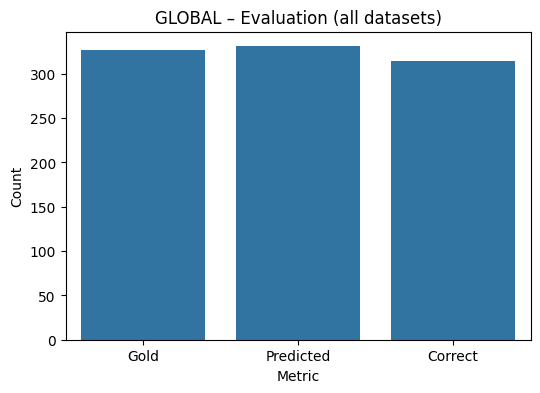

In [9]:
run()

